# Darknet Clone하기 yolo사용을 위함.


In [1]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15185, done.
remote: Total 15185 (delta 0), reused 0 (delta 0), pack-reused 15185
Receiving objects: 100% (15185/15185), 13.59 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (10310/10310), done.


In [2]:
%cd darknet

/content/darknet


In [3]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
#Compile Darknet
!make

In [5]:
#COCO dataset으로 pretrained 된 데이터셋 사용.
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-07-01 14:59:45--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   102MB/s    in 2.3s    

2021-07-01 14:59:48 (102 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



# OpenCV

In [6]:
import cv2
import IPython
import numpy as np
import time
import math
from google.colab.patches import cv2_imshow

In [18]:
min_confidence = 0.5
weight_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'
name_file = 'data/coco.names'

file_name = '000f8d37-d4c09a0f.mp4' # 다운받은 동영상.

In [19]:
net = cv2.dnn.readNet(weight_file, cfg_file)

In [9]:
classes = [] #COCO dataset의 클래스.
with open(name_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [10]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [17]:
# 000f8d37-d4c09a0f.mp4 DeepDrive에서 받아옴.
from google.colab import files
files.upload()

Saving 000f8d37-d4c09a0f.mp4 to 000f8d37-d4c09a0f.mp4


In [13]:
frame_count = 0
writer = None
output_name = 'output_video.avi'

In [20]:
def writeFrame(img):
    global writer
    height, width = img.shape[:2]
    if writer is None and output_name is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
    if writer is not None:
        writer.write(img)

In [21]:
def detectAndDisplay(frame):
    global frame_count
    frame_count += 1
    start_time = time.time()
    IPython.display.clear_output(wait=True)
    height, width, channedls = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > min_confidence:

                # Object detect
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Region of Interest Box를 그리기 전에 해줘야 box를 인식 안함.
    mask = np.zeros((height,width), dtype='uint8')
    poly_top = int(0.65 * height)
    poly_bottom = int(0.85 * height) #바닥을 만들어서 차의 앞부분을 안보이게하기.
    poly_left = int(0.47 * width)
    poly_right = int(0.53 * width)
    poly_margin = 50
    polygons = np.array([[(0+poly_margin,poly_bottom), (poly_left, poly_top), (poly_right, poly_top), (width-poly_margin, poly_bottom)]])
    cv2.fillPoly(mask, polygons, 255)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
    font = cv2.FONT_HERSHEY_COMPLEX
    margin = 5
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            print(class_ids[i], label)
            color = colors[i]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label, (x, y + 30), font, 0.5, (0, 255, 0), 1) 

            # Bitwise operation between box and mask 비트와이즈 연산. 박스에 마진을 넣어주기
            box = np.array([[(x-margin, y+h+margin), (x-margin, y-margin), (x+w+margin, y), (x+w+margin, y+h+margin)]])
            cv2.fillPoly(mask, box, 0) 
    cv2_imshow(mask)
    
    # Lane Detection 을 위한 부분
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # GaussianBlur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 40, 130) #윤곽선

    # Bitwise operation between poly and mask
    masked = cv2.bitwise_and(canny, mask)
    cv2_imshow(masked)
    # Lane Detection
    lines = cv2.HoughLinesP(masked, 2, np.pi / 180, 20, np.array([]), 20, 10)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(frame, (x1,y1), (x2,y2), (0,  255, 255), 5)

    frame_time = time.time() - start_time 
    print("Frame {} time {}".format(frame_count, frame_time))
    cv2_imshow(frame)   
    writeFrame(frame)

2 car
5 bus
2 car
2 car
0 person
0 person
0 person
2 car
2 car
0 person
2 car


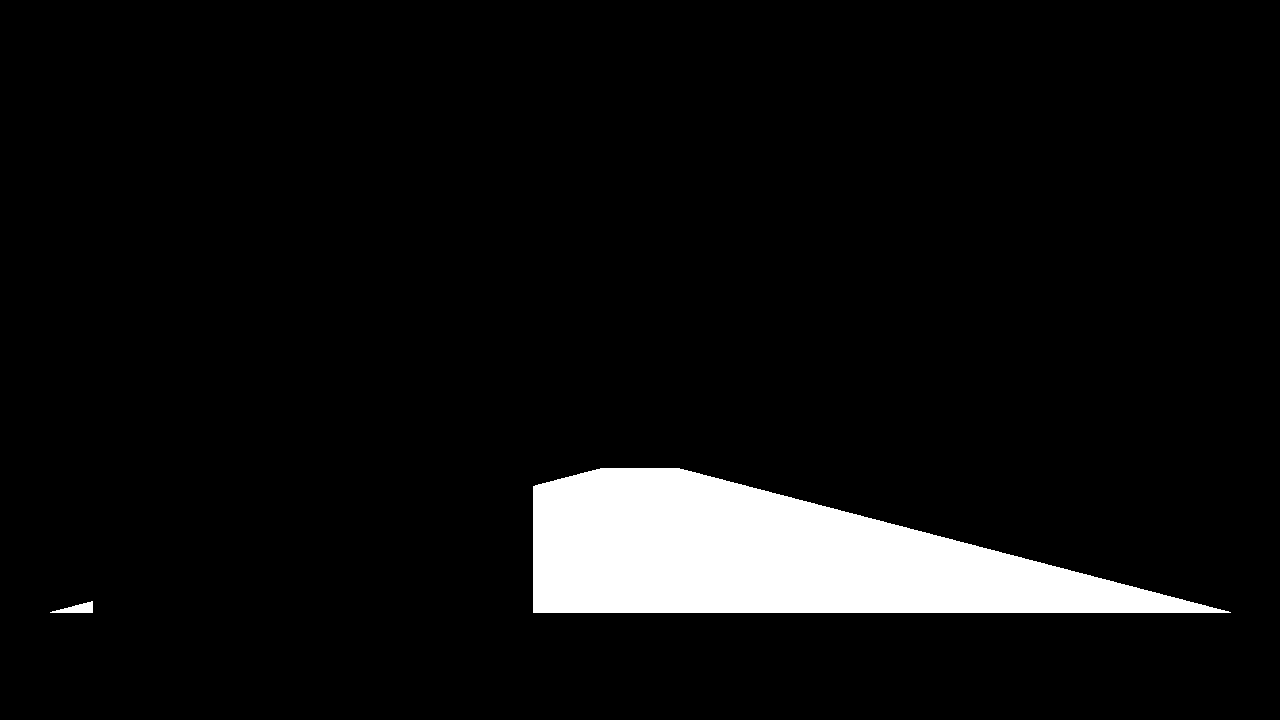

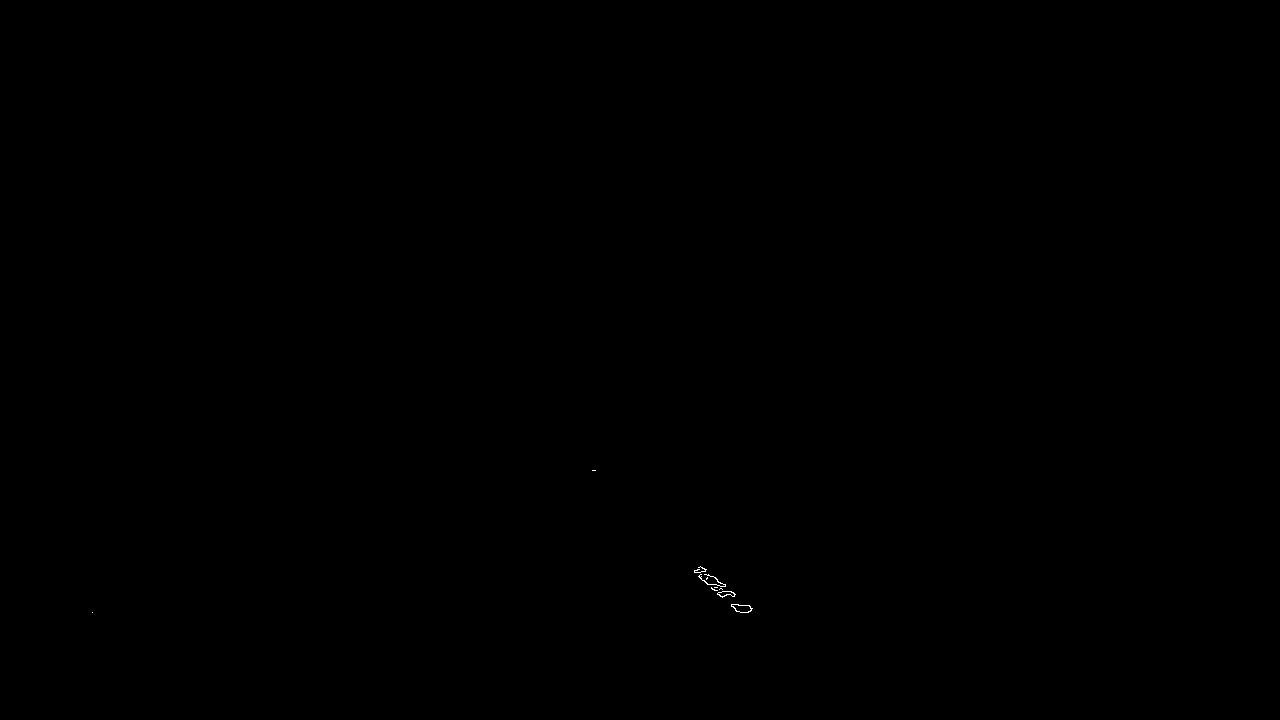

Frame 2415 time 1.943427324295044


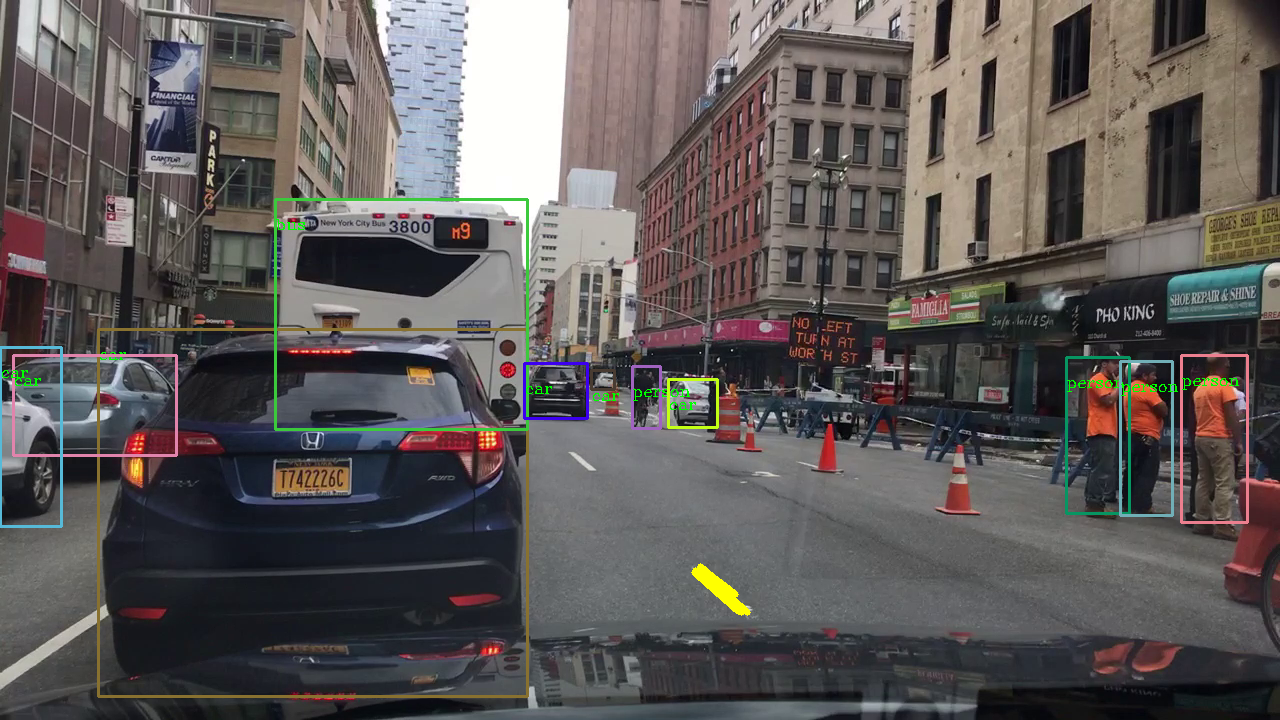

--(!) No captured frame -- Break!


In [22]:
# 동영상 detection
cap = cv2.VideoCapture(file_name)
if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0) 
while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break
    detectAndDisplay(frame)